In [1]:
import os

os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
from urbanstats.games.quiz_analysis import get_full_statistics, get_named_users
from urbanstats.website_data.colors import hue_colors

In [4]:
named_users = get_named_users()

In [5]:
result_full = get_full_statistics(after_problem=1, debug=False)
mapping = dict(zip(result_full.raw_user_id, result_full.user_id))

In [6]:
scores_full = result_full[["raw_user_id", "problem", "score"]].pivot(index="raw_user_id", columns="problem", values="score")
scores_full = scores_full.groupby([mapping[x] for x in  scores_full.index]).min()
scores_full = scores_full[scores_full.T.count() > 10]
scores_normalized = scores_full - scores_full.sum() / scores_full.count()
scores_unnormalized = scores_full.T.mean()
scores_by_person = scores_normalized.T.mean()
counts = scores_normalized.T.count()

In [7]:
def query(*days_patterns):
    result = [
        result_full[
            (result_full.problem == day)
            & (result_full.pattern.apply(lambda x: x.tolist() == pattern))
        ].user_id
        for day, pattern in days_patterns
    ]
    result = [set(x) for x in result]
    from collections import Counter
    ctr = Counter(x for xs in result for x in xs)
    ctr = sorted(ctr.items(), key=lambda x: -x[1])
    return [(id, c - len(days_patterns), c / len(days_patterns)) for id, c in ctr]

In [8]:
gap = 50
offy = 4
offx = 0.01

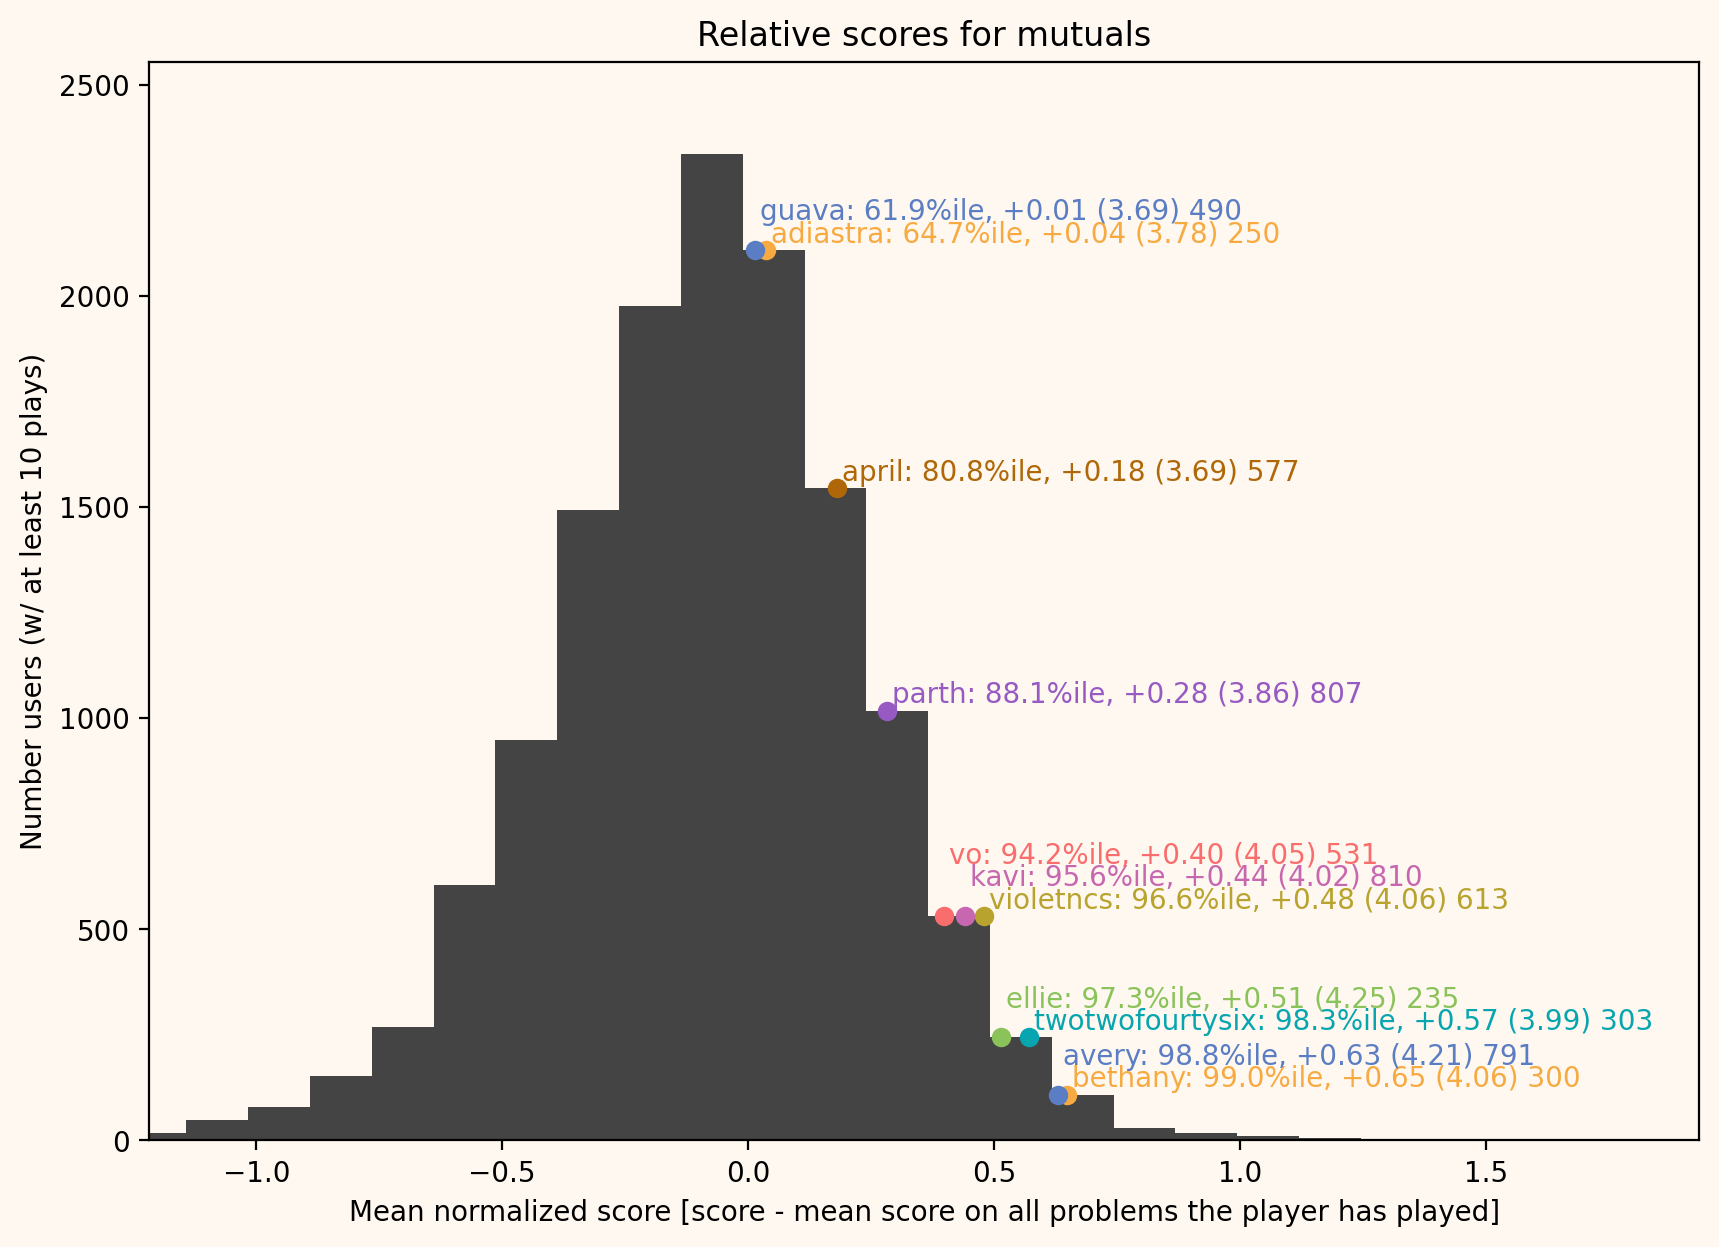

In [9]:
def load_matplotlib_local_fonts():
    import matplotlib
    import matplotlib.font_manager as font_manager

    # Load a font from TTF file, 
    # relative to this Python module
    # https://stackoverflow.com/a/69016300/315168
    font_path = os.path.join(os.getcwd(), 'icons/fonts/Jost/static/Jost-Regular.ttf')
    assert os.path.exists(font_path)
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    #  Set it as default matplotlib font
    matplotlib.rc('font', family='sans-serif') 
    matplotlib.rcParams.update({
        # 'font.size': 12,
        'font.sans-serif': prop.get_name(),
    })

load_matplotlib_local_fonts()

bg = "#fff8f0"
plt.figure(dpi=200, facecolor=bg,  figsize=(10, 7))
plt.gca().set_facecolor(bg)
plt.style.use('default')
c, b, _ = plt.hist(scores_by_person, bins=30, color="#444")
colors = ([y for x, y in hue_colors.items() if "grey" not in x.lower()] * 10)[:len(named_users)]
texts = []
last_y = -float("inf")
for k, color in zip(sorted(named_users, key=lambda x: scores_by_person[named_users[x]])[::-1], colors[::-1]):
    u = named_users[k]
    x = scores_by_person[u]
    y = c[np.max(np.where(b < x))]
    percentile = (scores_by_person < scores_by_person[u]).mean() * 100
    label = f'{k}: {percentile:.1f}%ile, {scores_by_person[u]:+.2f} ({scores_unnormalized[u]:.2f}) {counts[named_users[k]]}'
    plt.scatter(
        x,
        y,
        color=color
    )
    y = max(last_y + gap, y)
    y += offy
    x += offx
    last_y = y
    text = plt.text(x=x,y=y,s=label, color=color, ha="left", va="bottom")
    texts.append(text)
# adjustText.adjust_text(texts, max_move=1000000, force_text=3, only_move=dict(text="y"))
plt.xlabel("Mean normalized score [score - mean score on all problems the player has played]")
plt.ylabel("Number users (w/ at least 10 plays)")
plt.xlim(np.percentile(scores_by_person, 0.25), plt.xlim()[1] + 0.5)
plt.ylim(plt.ylim()[0], plt.ylim()[1] + 100)
plt.title("Relative scores for mutuals")
# plt.legend()
plt.show()

In [10]:
worst_player = scores_by_person.index[scores_by_person.argmin()]
best_player = scores_by_person.index[scores_by_person.argmax()]

In [11]:
for key, ident in zip(("worst player", "best player"), (worst_player, best_player)):
    vec = scores_full.loc[ident]
    print(key)
    print(f"Average: {vec.mean():.2f} [rel expectation: {scores_normalized.loc[ident].mean():+.2f}]")
    vec = vec.loc[~np.isnan(vec)]
    print("; ".join(f"{prob}: {int(v)}/5" for prob, v in zip(vec.index, vec)))
    print()

worst player
Average: 1.09 [rel expectation: -2.52]
221: 4/5; 239: 4/5; 425: 1/5; 430: 1/5; 443: 0/5; 447: 0/5; 454: 0/5; 466: 0/5; 569: 2/5; 599: 0/5; 617: 0/5

best player
Average: 4.88 [rel expectation: +1.25]
387: 4/5; 388: 4/5; 389: 4/5; 390: 4/5; 391: 4/5; 392: 5/5; 393: 5/5; 394: 5/5; 395: 5/5; 396: 5/5; 397: 5/5; 398: 5/5; 400: 5/5; 401: 5/5; 402: 5/5; 403: 5/5; 405: 4/5; 406: 5/5; 407: 5/5; 408: 5/5; 409: 5/5; 410: 5/5; 412: 5/5; 413: 5/5; 414: 5/5; 415: 5/5; 416: 5/5; 417: 5/5; 419: 5/5; 420: 4/5; 421: 5/5; 422: 5/5; 423: 5/5; 424: 5/5; 425: 5/5; 426: 5/5; 428: 5/5; 429: 5/5; 430: 5/5; 434: 5/5; 435: 5/5; 436: 5/5; 437: 5/5; 438: 5/5; 442: 5/5; 443: 5/5; 444: 5/5; 445: 5/5; 448: 5/5; 449: 5/5; 450: 5/5; 451: 5/5; 452: 5/5; 455: 5/5; 456: 5/5; 458: 5/5; 463: 5/5

